<b>Prérequis pour ce notebook</b> :<br>
Les cellules de ce notebook sont codées pour être exécutées dans l'ordre.<br>
Les modules ci dessous sont nécessaires pour son fonctionnement.<br>
Si certains doivent être installés, la commande pip est mis en commentaire.<br>
Ne pas oublier de mettre à jour les modules utilisés avant execution<br>

__Remarque :__ L'execution de certaines cellules (utilisant la Boruta) peuvent prendre plusieurs minutes.

In [1]:
# Affichage
%matplotlib notebook
from IPython.display import display, HTML


# Modules standards
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import numpy as np


# Méthode de préprocessing utilisés
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Classifiers utilisés
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,\
                             AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier



## Modules particuliers :
from boruta_py import BorutaPy # This module is include within the git repository

# Introduction

Notre analyse portera sur une base de données contenant <b>6000 vins</b>. La base a été récupérée sur le site du Center for Machine Learning and Intelligent Systems de UCL. Le dossier recueilli contient deux bases de données ayant le même ensemble de variables. Chaque base concerne une couleur de vin différente : vin rouge et vin blanc.
Chaque vin est <b>décrit par 11 de ses propriétés chimiques</b> ainsi qu'une note. Cette note est la moyenne d'un panel d'expert.<br>

Pour faciliter les traitements, nous concaténons les deux bases en une seule en ajoutant une variable indiquant la couleur du vin. La variable dépendante prend des valeur dans {3, 4, 5, 6, 7,8, 9}. On a donc affaire à un outcome discret et ordonné. Le problème de prévision de cette variable peut donc être vu comme un problème de classification ou comme un problème de régression. Nous ne retiendrons que la première approche.

<b>L'objectif est de prédire la note d'un vin à partir de ses propriétés chimiques.</b><br>

Nous commencerons par une bréve analyse de la base de données avec quelques statistiques descriptives.<br>
Ensuite nous entamerons le machine learning avec la création de classes pour nous faciliter le travail.<br>
Le learning est décomposé comme suit :<br>
<ul>
    <li>Réalisation de n test avec p classifiers sur notre base de données.</li>
    <li>On récupére le meilleur c'est à dire celui qui à le meilleur score en tenant compte de la variance.</li>
    <li>On analyse les résultats du meilleur.</li>
</ul>
Cette méthode classique nous a permis d'atteindre un score moyen de 68%.

Pour essayer d'améliorer ce score nous avons voulu :
<ul>
    <li>Créer notre propre classifier qui tire partie des résultats d'analyse du meilleur.</li>
    <li>Refaire notre analyse mais cette fois avec les interactions au premier ordre.</li>
</ul>
Aucune de ces tentatives ne s'est révèlée fructueuse.


# Récupération des données

Nous récupérons les données sur les vins avec leurs notes (disponible <a href="http://archive.ics.uci.edu/ml/datasets/Wine+Quality">ici</a>).

La base de donnée est bien stocké sous format csv et elle ne pose pas de difficulté à traduire en un dataframe.

## Utilities

In [2]:
def read(name):
    return pd.read_csv("data/"+name+".csv", sep=";")

## Récupération des données et fusion 

In [3]:
# Récupération des données CSV
whites = read("winequality-white")
reds = read("winequality-red")

# Ajout de la colonne pour la couleur du vin (Rouge = 0 et Blanc = 0)
reds["color"] = pd.Series(0, index=reds.index)
whites["color"] = pd.Series(1, index=whites.index)

# Création d'un dataframe de tous les vins
wines = reds.append(whites, ignore_index=True)
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.400000,5,0
1,7.8,0.880,0.00,2.60,0.098,25.0,67.0,0.99680,3.20,0.68,9.800000,5,0
2,7.8,0.760,0.04,2.30,0.092,15.0,54.0,0.99700,3.26,0.65,9.800000,5,0
3,11.2,0.280,0.56,1.90,0.075,17.0,60.0,0.99800,3.16,0.58,9.800000,6,0
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.400000,5,0
5,7.4,0.660,0.00,1.80,0.075,13.0,40.0,0.99780,3.51,0.56,9.400000,5,0
6,7.9,0.600,0.06,1.60,0.069,15.0,59.0,0.99640,3.30,0.46,9.400000,5,0
7,7.3,0.650,0.00,1.20,0.065,15.0,21.0,0.99460,3.39,0.47,10.000000,7,0
8,7.8,0.580,0.02,2.00,0.073,9.0,18.0,0.99680,3.36,0.57,9.500000,7,0
9,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.500000,5,0


# Statistiques descriptives

Pour mieux connaitre les variables de notre base de données, nous allons débuter par des statistiques descriptives.

## Distribution des notes

<IPython.core.display.Javascript object>


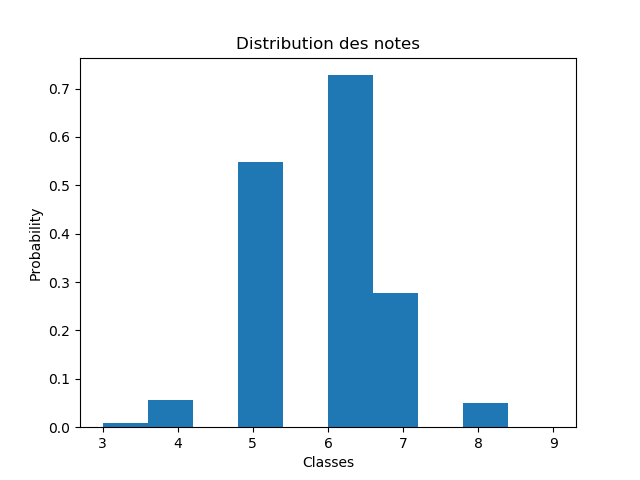

In [41]:
Graphique=plt.figure()
plt.hist(wines['quality'],normed=1)
plt.title("Distribution des notes")
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.show()

L'analyse de la variable d'intérêt montre un problème de balancement des classes.
En effet, on observe une sur-représentation des vins ayant une note moyenne relativement aux vins ayant une note " extrême", comme le montre le graphique ci-dessus. Nous reviendrons sur ce point durant la phase de machine learning en proposant un classifier en deux étapes.


## Matrice de corrélation

Nous allons mettre évidence les distinctions chimiques entre vins rouges et vins blancs.
Pour cela, nous allons commencer à étudier la matrice de corrélation.

<IPython.core.display.Javascript object>


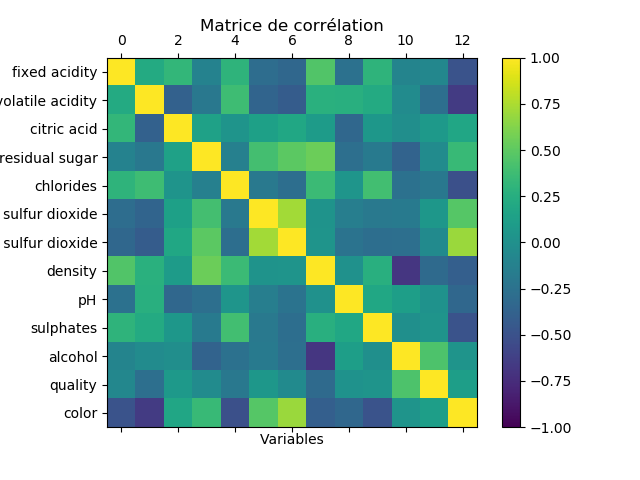

In [35]:
# Création de la matrice de corrélation
correlations = wines.corr()
names=wines.columns

# Affichage de la matrice
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(names),1)

ax.set_yticks(ticks)
ax.set_yticklabels(names)

plt.xlabel('Variables')

plt.title("Matrice de corrélation")

plt.show()

La matrice des corrélations entre variables est donnée dans le graphique ci-dessus.
La chose la plus frappante est la très forte corrélation entre la couleur du vin (variable "color") et les autres variables, notamment le niveau et la volatilité de l'acidité, le sulfure de dioxide et le pH. 

## Distribution du taux d'alcool en fonction de la note

La matrice de corrélation nous montre également que la qualité est relativement fortement corrélée au taux d'alcool (corrélation supérieure à 0,4). Une étude de la distribution de ce taux en fonction de la note obtenue (graphique ci-dessous) permet de constater que les vins ayant eu une très bonne note (note >8) et ceux ayant obtenus une basse note (note <5) ont la même distribution du taux d'alcool. L'alcool ne semble donc pas être un critère discriminant pour classer un vin en "très bon" ou "très mauvais". Une des explications possible serait qu'une dose inférieur d'alcool autoriserait un classement plus fin des vins car permettrait de faire davantage ressortir les autres caractéristiques ; un taux d'alcool important agirait ainsi comme un dissimulateur des autres variables, empêchant le vin d'être apprécié à sa juste valeur. 



<IPython.core.display.Javascript object>


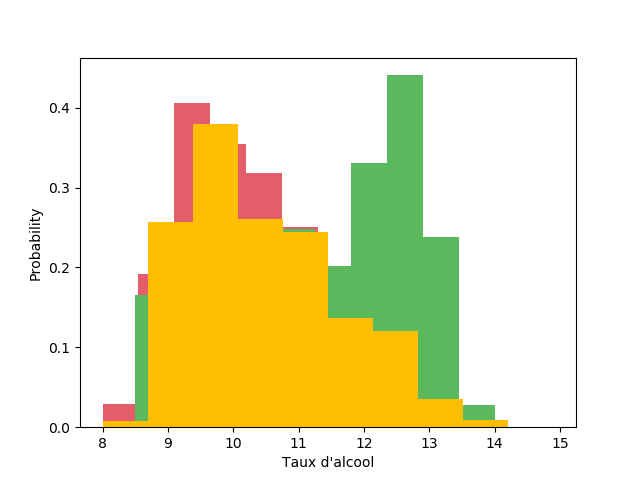

In [43]:
fig = plt.figure()
plt.hist(wines[(wines['quality']<5)]['alcohol'],normed=1, color="#e35d6a")
plt.hist(wines[(wines['quality']>7)]['alcohol'],normed=1, color="#5cb85c")
plt.hist(wines.loc[wines['quality'].isin([5,6,7])].alcohol,normed=1, color="#ffbf00")
plt.xlabel('Taux d\'alcool')
plt.ylabel('Probability')
plt.show()

## Distinction chimique entre vin rouge et blanc

On s'intéresse à présent aux différences entre les moyennes empiriques de chaque variable.
Le graphique ci-dessous illustre les divergences entre vin blanc et rouge. Ici c'est le vin blanc qui est tracé. Le vin rouge étant ce même graphe avec des valeurs négatives. On peut constater que les vins différent très peu en taux d'alcool. Ils se distinguent dans leurs taux de sucres, chlorides et de sulfur dioxide à plus de 30%.
On retrouve là un résultat assez connu des amateurs de vin : les vins rouge ont tendance à être moins sucrés que les vins blancs. Ce résultat nous permet de mettre en doute la pertinence de l'inclusion de la couleur en entrée des modèles. En particulier, inclure la variable "free sulfur dioxide" permet de capter (quasi)-parfaitement la couleur du vin ; cette dernière n'ayant donc a priori pas besoin d'être incorporée dans l'entrée des algorithmes.


<IPython.core.display.Javascript object>


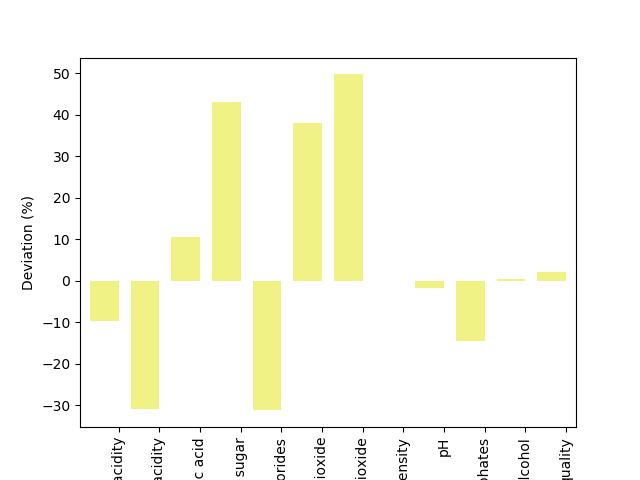

In [7]:
wines_mean = (whites.mean() + reds.mean())*0.5
whites_feats = (whites.mean()/wines_mean - 1)*100

fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.7

whites_feats.drop("color").plot(kind='bar', color='#f1f285', ax=ax, width=width, position=1)
ax.set_ylabel('Deviation (%)')
plt.show()

In [8]:
wines.columns.values

array(['fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality', 'color'], dtype=object)

# Machine learning - Classification supervisée

## Utilities

Pour faire nos classifications nous utiliserons des classes pour nous permettre de tester rapidement divers modèles sur notre base de données.

__ClassifierTester :__<br>
Cette classe permet de tester à la suite plusieurs modèle sur une base de données splittée spécifique. Elle retourne des classifierScore pour chaque test et les stocke.

__ClassifierScore :__<br>
Cette classe stocke le résultat de la classification. Elle conserve la base sur laquelle la classification a été effectuée et le score. Elle permet d'afficher proprement les résultats de tous les tests pour le classifierTester.

__ClassifierTester :__<br>
Cette classe permet de réaliser n test de plusieurs classifiers. L'objectif est de déterminer quelle classifier sont les plus stables et les plus efficaces.<br>
Elle permet aussi de mettre en cache les calculs précédents. Cela évite de recalculer à chaque fois les n classifications. 

### ClassifierTester

In [9]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from boruta_py import BorutaPy


from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import ExtraTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier



#
#   Classe permettant de tester rapidement sur une base une série de classifiers.
#
class ClassifierTester:
    
    # Les classifiers que l'on souhaite tester
    clfs_name = [\
                "RandomForestClassifier",
                #"RandomForestRegressor",
                "SGDClassifier",
                "ExtraTreeClassifier",
                "RidgeClassifier",
                "SVC", 
                "KNeighborsClassifier",
                "AdaBoostClassifier",
                "GradientBoostingClassifier"
           ]    
    
    # A l'initialisation récupère les données et les splits.
    def __init__(self, data, col):
        self.data = data # Base de données
        self.col = col # Colonne à prédire
        self.scores = {} # Stocke les résultats des différents classifiers
        
        self._split_normalize_data() # Split et normalise les date
 
#
#   Fonctions privées d'analyses des données
#
        
    # Split les datas en deux set de train et de test.
    # Normalise ensuite les sets sur le set de train.
    def _split_normalize_data(self):
        # Reset results
        self.scores = {}
        
        # Split datas
        train, test = train_test_split(self.data)    

        # Split X, Y
        self.train_X, self.train_Y = train.drop(self.col, 1), train[self.col]
        self.test_X, self.test_Y = test.drop(self.col, 1), test[self.col]
        
        # Normalizing      
        # Très important de mettre le test avant !!!!!!
        # car train_x ne doit pas etre encore normalisé pour normalisé test_x (sinon on soustrait juste par 1)
        self.test_X = (self.test_X - self.train_X.mean())/self.train_X.std()
        self.train_X = (self.train_X - self.train_X.mean())/self.train_X.std()
    
        
        return self
        

    # Test un classifier (clf) sur les features (feat_selector) de la base de données.
    # Retourne un ClassifierScore
    def _test(self, clf, feat_selector = None, suffixe = ""):
        
        # Recupere le nom des colonnes selectionnées
        if feat_selector is None:
            feats_selected = self.train_X.columns
        else:
            feats_selected = [i for indx,i in enumerate(self.train_X.columns) if feat_selector[indx]]
        
        # Train le classifier sur les feats_selected
        selected_train = self.train_X[feats_selected]
        clf.fit(selected_train,self.train_Y)

        # Crée et stocke le score du classifier
        score = ClassifierScore(clf, feats_selected, self.test_X, self.test_Y, suffixe)
        self.scores[score.name] = score
        return score
    
    
    # Retourne les features optimisées pour le classifier (clf)
    # Avec la méthode de boruta (ne marche que sur des sklearn.ensemble)
    # WARNING -> C'est assez long ! (1-2 minutes par classifieur)
    def _boruta_selector(self, clf):
        feat_selector = BorutaPy(clf, n_estimators=100, verbose=0, random_state=1)
        feat_selector.fit(self.train_X.values, self.train_Y.ravel())
        return feat_selector.support_
    
    def _has_boruta(self, clf):
        return ("RandomForest" in str(type(clf)))
 


#
#  Fonctions d'interface
#
    
    # Test un classifier avec la boruta si démandé et si possible.
    # Retourne un ClassifierScore
    def test(self, clf, boruta = False):
        
        # Test simple avec toutes les features
        score = self._test(clf)
        
        # Essaie de faire une boruta si demandés.
        if boruta and self._has_boruta(clf):
            try:
                # On rajoute le suffixe pour que la boruta n'écrase pas l'autre score
                score = self._test(clf, self._boruta_selector(clf), "_Boruta")
            except:
                print("Boruta failed...")
        
        return score
        
    
    
    # Teste tous les classifiers en réserve
    def full_test(self, clfs_name = None, boruta = False):
        # Valeur par default des classifieurs à tester.
        if clfs_name == None : clfs_name =  self.__class__.clfs_name
        
        # Test tous les classifiers
        for clf_name in clfs_name:
            clf = eval(clf_name + "()") # Crée le classifier
            self.test(clf, boruta = boruta) # Test le classifier et stocke le résultat
        
        return self
    
    def get_dict_score(self):
        res = {}
        for key, value in self.scores.items():
            res[key] = value.score
        return res
        
    
    
#
#  Fonctions d'affichage
#      

    # Affiche tous les scores stockés
    def __str__(self):
        s = ""
        for name, score in self.scores.items():
            s += str(score) + "\n"
        return s
    
    def __repr__(self):
        return self.__str__()
    
#
#  Fonctions utiles
#

    def __getitem__(self, key):
        if key not in self.scores:
            raise ValueError("'"+key+"'is not in the score !")
        return self.scores[key]

### ClassifierScore

La principale fonctionalitée de cette classe est d'utiliser la fonction \__str__. Cela permet de mettre en forme rapidement les résultats du ClassifierTester.<br>
Elle n'est pour l'instant pas très complexe mais pourra être facilement améliorer pour d'autres projets.

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

class ClassifierScore:
    
    def __init__(self, clf, feats_selected, X, Y, suffixe = ""):
        self.clf = clf
        self.feats_selected = feats_selected
        self.X = X
        self.X_selected = self.X[feats_selected]
        self.Y = Y
        self.Y_pred = clf.predict(self.X_selected)
        self.name = str(type(self.clf).__name__) + str(suffixe)
        
        self.feats_removed = [c for c in X.columns if (c not in feats_selected)]
        
        self._compute()
        
    # Calcule les scores
    def _compute(self):
        self.score_random = 1/self.Y.nunique()
        self.score = self.clf.score(self.X_selected, self.Y)
        self.score_diff = (self.score/self.score_random) - 1
        
        print(self.name + " computed ! ("+self._to_per(self.score)+")")
        
    def cross_validation(self):
        return confusion_matrix(self.Y, self.Y_pred)
        
#
#  AFFICHAGE
#      
    def __str__(self):
        res = "Résultat pour " + self.name + "\n"
        res += "Score minimum significatif : " + self._to_per(self.score_random) + "\n"
        res += "Score de la classification : " + self._to_per(self.score) + "\n"
        res += "Amélioration de " + self._to_per(self.score_diff) + "\n"
        res += "Colonne éliminée : " +  ("Aucune" if len(self.feats_removed) == 0 else ", ".join(self.feats_removed)) + "\n"
        res += "Colonne gardée : " +  ("Aucune" if len(self.feats_selected) == 0 else ", ".join(self.feats_selected)) + "\n"

        return res
    
    def __repr__(self):
        return self.__str__()
    
#
#  Utilities
#
    def _to_per(self, p):
        return str(round(100*p,2)) + "%"  

### NClassifierTester

Cette classe réalise N tests sur tous les classifiers sur une base de données spécifique. L'objectif est de pouvoir tester mais surtout de stocker les résultats pour qu'à chaque execution de l'algorithme le nombre de résultats augmente.<br>
Elle stocke uniquement le score de chaque test pour chaque classifier sous forme d'un DataFrame.<br>
En résumé, c'est un cache pour les tests.

In [44]:
import pickle
import os
from IPython.display import display, HTML

class NClassifierTester:
    folder = "data/" # Dossier où seront stockés les résultats.
        
        
    # Test n fois tous les classifiers dans clfs
    # name : nom du test (utilisé pour le nom du pickle)
    # data : base de donnée pour les tests
    # column : colonne à prédire
    # n : Nombre de test à effectuer.
    # clfs : Classifiersà tester (par défault ceux du ClassifierTester)
    # boruta : si on utilise l'algo de boruta
    # over : si on remplace le cache
    def test(self, name, data, column, n = 10, clfs = ClassifierTester.clfs_name, boruta = False, over = False):
        # Récupére le cache
        cache = pd.DataFrame() if over else self._load_cache(name)
            
        # Calcul le nombre de test restant à effectué avec le cache     
        n_done = len(cache.index)
        n_todo = n - n_done
        
        if n_todo > 0:
            # Réalise les n tests
            for i in range(n_todo):   
                print("Iteration : "+ str(i+1) + "/" + str(n_todo))
                tester = ClassifierTester(data, column)
                tester.full_test(clfs, boruta)
                
                scores = tester.get_dict_score()
            
                # Fusionne le nouveau test dans le dataFrame
                cache = cache.append(scores, ignore_index=True)
                # Sauvegarde le cache
                self._save_cache(name, cache)
                
                ## On cache à chaque étape car pour une boruta le calcul peut etre long
                ## Ainsi si on stop l'algo avant n on ne perd pas tous les calculs
        
        self.show(name)
        return cache
    
    
    
    # Affiche les moyennes et écarts-types de l'analyse $name
    def show(self, name):
        df = self._load_cache(name)
        
        ms = df.mean().sort_values(ascending = False)*100
        stds = df.std()*100

        data = np.array([ms.values, stds[ms.index].values]).transpose()
   
        print(name + " comprenant "+str(len(df.index))+" tests :")   
        display(pd.DataFrame(data, index = ms.index, columns = ["Moyenne", "Ecart type"])) 

        
#
# Gestions du caches
#
    
    # Charge le cache s'il existe ou retourne un dataframe vide
    def _load_cache(self, name):
        path_file = self.__class__.folder + name + ".pickle"
        if os.path.isfile(path_file):
            return pickle.load( open(path_file, "rb" ) )     
        else:
            return pd.DataFrame()
        
        
    # Sauvegarde le cache
    def _save_cache(self, name, cache):
        path_file = self.__class__.folder + name + ".pickle"
        pickle.dump( cache, open(path_file, "wb" ) )
        return self

## Prédiction de la couleur du vin

On cherche à prédire la couleur du vin à partir de ces caractéristiques chimiques.
Comme vu plus haut le vin blanc se distingue du rouge distinctivement sur plusieurs caractéristiques.
On peut donc s'attendre à un score élévé.

In [45]:
data = wines.drop(["quality"], 1)

NTester = NClassifierTester()
df = NTester.test("origin_base_boruta_color", data, "color", n = 40, boruta = False) # Boruta does not work

origin_base_boruta_color comprenant 40 tests :


,Moyenne,Ecart type
SVC,99.593846,0.134968
RidgeClassifier,99.460000,0.178729
GradientBoostingClassifier,99.380000,0.172593
KNeighborsClassifier,99.306154,0.165470
AdaBoostClassifier,99.301538,0.153641
RandomForestClassifier,99.280000,0.219106
SGDClassifier,98.996923,0.366909
ExtraTreeClassifier,97.756923,0.421760


On obtient un score très élévée. Cela confirme l'interprétation qui a été faite lors de l'analyse descriptive.

## Prédiction de la note

On cherche ici à prédire la note attribuée au vin en fonction de ses caractéristiques chimiques.

In [13]:
NTester = NClassifierTester()
df = NTester.test("origin_base_boruta_quality", wines, "quality", n = 30, boruta = True)

origin_base_boruta_quality comprenant 30 tests :


,Moyenne,Ecart type
RandomForestClassifier_Boruta,68.235897,1.093464
RandomForestClassifier,65.292308,0.964246
GradientBoostingClassifier,58.970256,1.404124
ExtraTreeClassifier,58.960000,1.508534
SVC,57.171282,1.188943
KNeighborsClassifier,55.478974,1.127988
RidgeClassifier,53.312821,1.103006
SGDClassifier,44.381538,4.322714
AdaBoostClassifier,36.080000,5.830444


On plafonne à 68% avec la RandomForest et un Boruta sur la base de données. L'écart type est de 1% ce qui est faible. Le classifier est donc stable.

On remarque que dans tous les cas la RandomForest est meilleure. Nous utiliserons donc dans la suite uniquement cet algorithme pour rafiner notre prédiction.

__Remarque :__ Nous n'avons pas effectuer de tuning des hypers paramètres. On suppose donc que le tuning ne changerait pas le classement des classifiers avec des gains à peu près similaires. Cette hypothèse n'est pas forte étant donné que le tuning apporte en général 2-3% et que nos classifiers ont des écarts de plus de 3%.

### Détails du score

In [14]:
tester = ClassifierTester(wines, "quality")
score_details = tester.test(RandomForestClassifier(), boruta = True)
score_details

RandomForestClassifier computed ! (63.32%)
RandomForestClassifier_Boruta computed ! (67.94%)


Résultat pour RandomForestClassifier_Boruta
Score minimum significatif : 14.29%
Score de la classification : 67.94%
Amélioration de 375.57%
Colonne éliminée : color
Colonne gardée : fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol

On constate que la Boruta élimine la feature de la couleur du vin. Cela confirme les résultats de la classification sur la couleur du vins qui montraient que la couleur était totalement déterminée par les propriétés chimiques.

#### Cross Validation

In [15]:
score_details.cross_validation()

array([[  0,   0,   3,   5,   0,   0,   0],
       [  0,   6,  28,  10,   2,   0,   0],
       [  0,   0, 349, 151,   5,   0,   0],
       [  0,   0, 116, 570,  52,   1,   0],
       [  0,   0,   6, 108, 163,   2,   0],
       [  0,   0,   2,  16,  13,  16,   0],
       [  0,   0,   0,   0,   1,   0,   0]])

Le classifier a de meilleurs résultats sur les vins moyens. Cette cross validation met ausi en évidence le peu de vin possédant des notes extremes.

#### Histogramme des notes

<IPython.core.display.Javascript object>


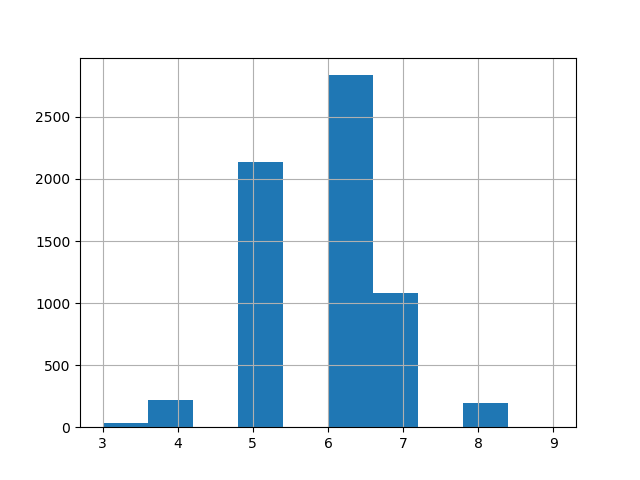

In [16]:
plt.figure()
wines.quality.hist()

On remarque que les notes sont très centrées. Il n'y a que très peu de notes extrèmes.

Le classifier est bon sur le milieu là où il y a beaucoup de vins. Nous allons tacher de montrer qu'il a plus de mal sur les extrèmes car il n'y a pas beaucoup d'échantillons, comme l'a montré par ailleurs notre étude descriptive de la base.

#### Séparation des vins

On sépare les vins en deux groupes :
<ul>
    <li>Les vins moyens (5,6,7)</li>
    <li>Les vins extremes (les autres)</li>
</ul>

In [17]:
quality_mains = [5,6,7] # Notes moyens

index_mains = wines['quality'].isin(quality_mains)

wines_mains = wines.loc[index_mains]
wines_ext = wines.loc[~index_mains]

#### Prédiction sur les notes moyennes

In [18]:
tester = ClassifierTester(wines_mains, "quality")
tester.test(RandomForestClassifier(), boruta = False)

RandomForestClassifier computed ! (67.44%)


Résultat pour RandomForestClassifier
Score minimum significatif : 33.33%
Score de la classification : 67.44%
Amélioration de 102.31%
Colonne éliminée : Aucune
Colonne gardée : fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, color

Le score est assez proche de celui sur tous les vins. Cela montre que la surrepresentation des vins moyens pousse l'algorithme à davantage prédire des notes moyennes que des notes extrêmes, cela lui permettant d'avoir, en moyenne, d'avantage raison.

#### Prédiction sur les notes extremes

In [19]:
tester = ClassifierTester(wines_ext, "quality")
tester.test(RandomForestClassifier(), boruta = False)

RandomForestClassifier computed ! (81.98%)


Résultat pour RandomForestClassifier
Score minimum significatif : 25.0%
Score de la classification : 81.98%
Amélioration de 227.93%
Colonne éliminée : Aucune
Colonne gardée : fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, color

Contrairement à ce que montrait la cross validation, les vins extremes sont beaucoup mieux prédits. Cependant la faible population pourrait induire de l'overfitting.

#### Prédiction de la classe des vins

Les classifiers fonctionnent donc mieux lorsqu'ils travaillent sur les classes de vins séparées (moyens et extremes).<br>
On va donc essayer d'avoir un classifier qui détermine à l'avance les vins moyens ou extremes.

In [20]:
data = wines.copy()
data["quality"] = data.quality.isin(quality_mains)
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.400000,True,0
1,7.8,0.880,0.00,2.60,0.098,25.0,67.0,0.99680,3.20,0.68,9.800000,True,0
2,7.8,0.760,0.04,2.30,0.092,15.0,54.0,0.99700,3.26,0.65,9.800000,True,0
3,11.2,0.280,0.56,1.90,0.075,17.0,60.0,0.99800,3.16,0.58,9.800000,True,0
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.400000,True,0
5,7.4,0.660,0.00,1.80,0.075,13.0,40.0,0.99780,3.51,0.56,9.400000,True,0
6,7.9,0.600,0.06,1.60,0.069,15.0,59.0,0.99640,3.30,0.46,9.400000,True,0
7,7.3,0.650,0.00,1.20,0.065,15.0,21.0,0.99460,3.39,0.47,10.000000,True,0
8,7.8,0.580,0.02,2.00,0.073,9.0,18.0,0.99680,3.36,0.57,9.500000,True,0
9,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.500000,True,0


In [21]:
tester = ClassifierTester(data, "quality")
tester.test(RandomForestClassifier(), boruta = False)

RandomForestClassifier computed ! (94.83%)


Résultat pour RandomForestClassifier
Score minimum significatif : 50.0%
Score de la classification : 94.83%
Amélioration de 89.66%
Colonne éliminée : Aucune
Colonne gardée : fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, color

Le score est élévé. La RF arrive très bien à distinguer les vins moyens des extrèmes.

# Approfondissement

## Custom Classifier

L'idée est de créer notre propre classifier. On a remarqué que le RandomForest est plus efficace sur les sous classes de vins (notes moyennes et extremes).<br>
Ce classifier va regrouper 3 sous classifiers (RandomForest).<br>

__ClassifierBinaire__ :<br>
Classe les vins en deux classes moyens ou extremes.<br>
Il partage l'échantillon et permet ensuite d'appliquer des classifieurs spécialisés.<br>

__ClassifierMains__ :<br>
Donne les notes des vins moyens.

__ClassifierOthers__ :<br>
Donne les notes des vins extremes.

__L'idée est de tirer partie des bons résultats sur chaque classe pour avoir un classifier au final plus puissant.__

Il s'agit donc d'une classification en double étape.

In [22]:
import numpy as np

class WinesClassifier():
    def __init__(self, quality_mains = [5,6,7]):
        self.quality_mains = quality_mains
        
    def fit(self, X, Y):
        Y_bin = Y.isin(self.quality_mains)
        self.bin_clf = RandomForestClassifier()
        self.bin_clf.fit(X, Y_bin)
        
        mains_index = Y.isin(self.quality_mains)
        
        self.clf_mains = RandomForestClassifier()
        self.clf_mains.fit(X.loc[mains_index], Y.loc[mains_index])
        
        self.clf_others = RandomForestClassifier()
        self.clf_others.fit(X.loc[~mains_index], Y.loc[~mains_index])
    
    
    
    # Fonction de prédiction pour un X
    # Etape 1 : Prédit si c'est un vin moyen ou non
    # Etape 2 : Retourne la note prédit par le classifieur spécialisé
    def _predict(self, x):
        if (self.bin_clf.predict(x)):
            return self.clf_mains.predict(x)
        else:
            return self.clf_others.predict(x)
        
        
    
    # C'est une fonction d'interface qui permet de gérer plusieurs types d'entrées
    # (Dataframe, list, numpy array, X)
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            return self.predict(X.values)
        
        elif isinstance(X, list):
            Y = []
            for x in X:
                Y.append(self._predict(x))
            return Y
        
        elif isinstance(X, np.ndarray):
            Y = []
            for x in X:
                Y.append(self._predict(x.reshape(1, -1)))
            return Y
        
        else:
            return self._predict(X)
        
    # Fonction de score
    # Assez longue car on traite chaque X un par un.
    def score(self, X, Y):
        i = 0
        for index, x in X.iterrows():
            y = self.predict(x.values.reshape(1, -1))
            if (y == Y[index]):
                i += 1
        return i/len(X)

In [23]:
NTester = NClassifierTester()
df_custom = NTester.test("origin_base_custom_quality", wines, "quality", n = 42, clfs = ["WinesClassifier"])

origin_base_custom_quality comprenant 42 tests :


,Moyenne,Ecart type
WinesClassifier,65.361172,1.129426


Les résultats sont décevants. Ce nouveau classifier a le même score qu'une RandomForest mais avec une variance plus élévée.<br>
Les résultats ne sont pas probants pour ce classifier.

# Introduction des croisements au premier ordre

Nous allons à présenter introduire les croisement au premier ordre  dans nos features.

## Ajout des croisements au premier ordre

Les méthodes de machines learning utilisent des techniques linéaires. Pour tenir compte des effets non linéaires, on ajoute les features de croisement au premier ordre (produits).

In [24]:
# On copie le tableau pour pouvoir faire des analyses avec et sans les corrélations
wines_c = wines.copy()

# On ne souhaite pas faire de corrélation sur quality et color
cols = wines_c.columns.drop(["quality", "color"])
n_cols = len(cols)

# Ajout des features de corrélations
for i in range(n_cols):
    for j in range(i, n_cols):
        a, b = cols[i], cols[j]
        wines_c[a + "_" + b] = wines_c[a]*wines_c[b]
        
# Affichage des corrélations
print("Nouvelles features de corrélations :")
for i in range(len(wines.columns), len(wines_c.columns)):
    print("\t" + wines_c.columns[i])

Nouvelles features de corrélations :
	fixed acidity_fixed acidity
	fixed acidity_volatile acidity
	fixed acidity_citric acid
	fixed acidity_residual sugar
	fixed acidity_chlorides
	fixed acidity_free sulfur dioxide
	fixed acidity_total sulfur dioxide
	fixed acidity_density
	fixed acidity_pH
	fixed acidity_sulphates
	fixed acidity_alcohol
	volatile acidity_volatile acidity
	volatile acidity_citric acid
	volatile acidity_residual sugar
	volatile acidity_chlorides
	volatile acidity_free sulfur dioxide
	volatile acidity_total sulfur dioxide
	volatile acidity_density
	volatile acidity_pH
	volatile acidity_sulphates
	volatile acidity_alcohol
	citric acid_citric acid
	citric acid_residual sugar
	citric acid_chlorides
	citric acid_free sulfur dioxide
	citric acid_total sulfur dioxide
	citric acid_density
	citric acid_pH
	citric acid_sulphates
	citric acid_alcohol
	residual sugar_residual sugar
	residual sugar_chlorides
	residual sugar_free sulfur dioxide
	residual sugar_total sulfur dioxide
	r

## Prédiction de la note avec les croisement au premier ordre

In [25]:
NTester = NClassifierTester()
df = NTester.test("corr_base_boruta_quality", wines_c, "quality", n = 10, boruta = True)

corr_base_boruta_quality comprenant 10 tests :


,Moyenne,Ecart type
RandomForestClassifier_Boruta,67.833846,0.693837
RandomForestClassifier,64.960000,0.809256
GradientBoostingClassifier,60.707692,1.213295
ExtraTreeClassifier,58.283077,1.426327
SVC,57.163077,1.047741
KNeighborsClassifier,56.092308,1.054467
RidgeClassifier,54.670769,0.913316
SGDClassifier,45.243077,2.521292
AdaBoostClassifier,37.200000,6.757612


Le score est en deça de la base de données classique. De plus, les temps d'execution sont très lents à cause du nombre important de feature.

L'ajout des croisement au premier ordre n'est donc pas probant : la meilleure solution reste donc la base initiale avec une RandomForest

## Détails du score

In [26]:
tester = ClassifierTester(wines_c, "quality")
score_details = tester.test(RandomForestClassifier(), boruta = True)
score_details

RandomForestClassifier computed ! (65.29%)
RandomForestClassifier_Boruta computed ! (68.25%)


Résultat pour RandomForestClassifier_Boruta
Score minimum significatif : 16.67%
Score de la classification : 68.25%
Amélioration de 309.48%
Colonne éliminée : fixed acidity, citric acid, residual sugar, free sulfur dioxide, total sulfur dioxide, pH, sulphates, color, fixed acidity_fixed acidity, fixed acidity_citric acid, fixed acidity_density, volatile acidity_volatile acidity, volatile acidity_citric acid, volatile acidity_residual sugar, citric acid_citric acid, citric acid_residual sugar, citric acid_total sulfur dioxide, residual sugar_residual sugar, chlorides_sulphates, chlorides_alcohol, free sulfur dioxide_free sulfur dioxide, free sulfur dioxide_total sulfur dioxide, free sulfur dioxide_density, free sulfur dioxide_pH, free sulfur dioxide_alcohol, total sulfur dioxide_total sulfur dioxide, total sulfur dioxide_density, total sulfur dioxide_pH, total sulfur dioxide_sulphates, total sulfur dioxide_alcohol, density_pH, pH_pH, sulphates_sulphates
Colonne gardée : volatile acidity

Boruta nous permet de conclure qu'un bon nombre de variables d'interaction première ne sont pas utiles pour la classification.<br>
La boruta s'avère donc utile pour éliminer les features mais est très lente.<br>

# Conclusion

En conclusion, il nous semble difficile d'obtenir un score supérieur à 70% avec cette base de données et des méthodes simples de machine learning, y compris en prenant en compte le non balancement de l'outcome. Ce résultat, bien que peu satisfaisant est néanmoinis toujours susceptible de donner une première indication à un vigneron quant à la qualité de son vin, ce qui est toujours appréciable. Il convient toutefois de garder en tête qu'il existe un risque d'erreur important. Une possibilité d'extension serait d'avoir recours à des réseaux de neuronnes.

# Annexe. Un point sur Boruta

Boruta est une méthode de features selection proposée par Kursa et Rudnicki [2010]. D'abord seulement disponible sous $R$, un module $Python$ est à présent disponible sous le nom de $Boruta.Py$. Alors que le package $R$ n'autorisait que la seule sélection à l'aide de la Random Forest, la version $Python$ est compatible avec tous les algorithmes ensemblistes de $Scikit Learn$.

L'algorithme Boruta permet de sélectionner des variables en prenant en compte la relation, l'imbrication, complexe des variables de la base de données afin d'obtenir le sous ensemble de variables V' de l'ensemble des variables V qui permettent de répondre au double objectif de maximisation de la prédiction et de parcimonie du nombre de variables utilisées.

L'algorithme Boruta suit le processus suivant :
<br>
<ul>
    <li>Étape 1.  Duplication de la base de données (ces duplicata étant appelés des "bases de données fantômes") et création des features fantômes en mélangeant aléatoirement les valeurs des lignes de chaque base de données "fantômes" ;</li> 

 <li>Étape 2. Concaténation de l'ensemble des bases de données fantômes avec la vraie base de données ; </li>

 <li> Étape 3. Entrainement d'un classifieur sur la base de données contenant les vraies variables et les variables fantômes. L'utilisation d'algorithmes comme la Random Forest ou le Gradient Boosted Trees permettent de capter l'ensemble des relations non linéaires entre les variables tout en gérant le problème du N<P ; </li>

 <li> Étape 4. Calcul du Z score de chaque variable ; </li> 

 <li> Étape 5. Recherche du Z score maximum parmi toutes les variables fantômes et assignation d'un "hit" à toutes les variables ayant un Z score supérieur. Pour toutes les autres variables, un test d'égalité (two-sided} avec le Z score maximum des variables fantômes est réalisé ; </li> 

 <li> Étape 6. Suppression de la base de données de toutes les variables pour lesquelles l'hypothèse nulle n'est pas rejetée ; </li> 

 <li> Étape 7. Suppression de la base de données de toutes les variables pour lesquelles l'hypothèse nulle n'est pas rejetée ; </li> 

 <li> Étape 8. Suppression des variables fantômes ; </li> 

 <li> Étape 9. Itération des étapes 1 à 8 jusqu'à ce que le nombre voulu de variables soit atteint ou qu'aucune variable ne soit rejetée ; </li> 
</ul>

La complexité de l'algorithme est de l'ordre de O(P * N). L'idée derrière Boruta est donc de conserver l'ensemble des variables ayant une corrélation avec la variable d'intérêt supérieure à la corrélation d'une variable aléatoire.
